## Lecture 13

#### Announcements
* Homework self-reflections - scores are recorded in the homework category
   * Thanks for your thoughtful answers; seems like things are going well overall.
* P3 is out! It's due in a week, but it's pretty short.
   * Pairs **required** for this one; find a partner during the break today!
   * Create your team and accept the GH classroom invite by class on Thursday.


#### Goals
* Understand and be prepared to implement the plane sweep stereo algorithm.
* Know how to represent lines in projective space.
* Understand how to determine interactions between points and lines in projective space:
  * How to check whether a point lies on a line
  * How to calculate the line through two points
  * How to calculate the intersection of two lines


In [2]:
# boilerplate setup
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
import sys

src_path = os.path.abspath("../src")
if (src_path not in sys.path):
    sys.path.insert(0, src_path)

# Library imports
import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt
import skimage as skim
import cv2

# codebase imports
import util
import filtering
import features
import geometry

### Plane Sweep Stereo

Rectified stereo: requires a very particular camera setup. 

What if they're not?

Two ways around this:
1. **Rectify** images so they appear *as if* the cameras were rectified.
2. **Plane sweep stereo**: Use camera matrices (intrinsics and extrinsics) to reason about depth directly.

Today we're focusing on plane sweep stereo. The setting:

* Cameras are *not* rectified, but
* They **are** calibrated, meaning we know:
    * $K_L$, $K_R$, the **intrinsics** of the left and right cameras.
    * $[R;t]_L$ $[R;t]_R$, the **extrinsics** of the left and right cameras. Note that:
        * These are written as 3x4 matrices, with $R_3x3$ augmented with $t_{3x1}$.
        * These are the matrices that go from world to camera; these are the inverses of the cameras' coordinate frame matrices.
     

Our standard stereo algorithm was:
```
for i, j in pixels:
  for d in disparities:
    compute a cost
```

The Plane sweep stereo algorithm swaps the outer loops:
```
for d in disparities:
  for i, j in pixels:
    compute a cost
```

The basic idea is to start with one camera, and:
1. "Unproject" each pixel to a hypothesized depth $d$.
2. "Reproject" the corresponding 3D points back into the *other* camera.
3. Compute a match score.

##### HW #1-2
Assume the following are known:
* intrinsics ($K_L, K_R$)
* extrinsics ($[R|t]_L, [R|t]_R$)

Note that here, we're representing the extrinsics as a $3\times 4$ augmented matrix $[R|t]$. This is the world-to-camera matrix with the projection built in, such that $\underset{3\times 1}{\mathbf{x}^{cam}} = \underset{3 \times 4}{[R|t]}  \underset{4 \times 1}{\mathbf{x}^{world}}$


**#2**: Given a 3D point $x_w, y_w, z_w$, write an expression for the pixel coordinates $x_{img}^R, y_{img}^R$ of that point in the right camera.

**#1**: Given a pixel coordinate $x_{img}^L, y_{img}^R$ in the left camera, give an expression for the 3D point at a hypothesized depth $d$​ that would have projected to that pixel location in the left camera.

#### The Algorithm
You could imagine doing this for every pixel, but it would be pretty expensive. However, we can make a key observation:

The "unproject-reproject" transformation is a homography!

We could calculate it directly from the camera matrices (for a given depth) but we'll use a slightly different approach:
1. Unproject the four corners of the left camera's image
2. Reproject the corners onto the right camera's image
3. Fit a homography $H_d$ from the four correspondences generated in (1-2)
4. Warp the left image using $H$
5. Compute NCC matching cost on the entire pair of images at once!
    * notice that this now is back to looking like a "sliding window" cross-correlation

#### Projective Geometry 1: Points and Lines

Leading up to the topic of **epipolar** geometry, which describes the geometric relationships between two or more cameras, we're going to start with some fundamentals regarding points and lines in projective space ($\mathbb{P}^2$).

The notes have more detail on the following, but here's the plan:

##### Homogeneous points

Review, and recall their interpretation as vectors / rays in $\mathbb{R}^3$.

##### Homogeneous lines
* Points (0D objects) in $\mathbb{P}^2$ can be interpreted as rays (1D objects) through the origin in $\mathbb{R}^3$.
* Lines (1D objects) in $\mathbb{P}^2$ can be interpreted as **planes** (2D objects) through the origin in $\mathbb{R}^3$!

After projection back onto the $w=1$ plane, a plane looks like a line!

We represent these in homogeneous coordinates also using 3-vectors $\ell = [a, b, c]$ that represent the **plane normal** in 3D. After projection, this corresponds to the 2D line equation $ax + by + c = 0$.

##### HW #3-4

3. Give the slope-intercept form of the line represented by homogeneous coordinates [1, 1, 0].

4. Give the homogeneous coordinates of the line $y = -2x + 400$.

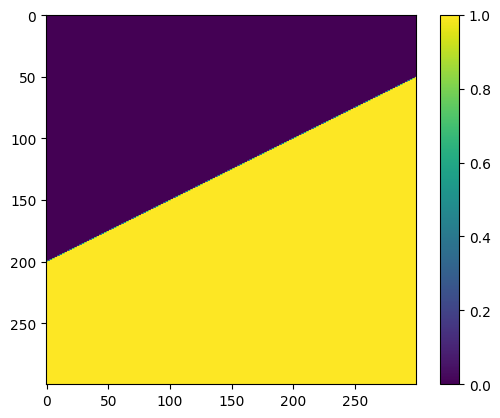

In [3]:
# TODO line_4 = 
line_4 = [2, 1, -400]

a, b, c = line_4
x, y = np.mgrid[:300, :300]

#plt.imshow(a*x + b*y + c)
plt.imshow(a*x + b*y + c > 0)
plt.colorbar()


#### Points on Lines; Lines through Points

The condition for whether a point $p$ lies on a line $\ell$, or equivalently that a line $\ell$ goes through a point $p$, is, elegantly:
$$
p \cdot \ell = 0
$$

##### HW #5: Show this algebraically

5. Recall that a homogeneous point $p = [x, y, w]$ represents the 2D coordinates $(x/w, y/w)$, while a line $\ell = [a, b, c]$ represents the 2D line $ax + by + c = 0$. Show *algebraically* that a line $\ell = [a, b, c]$ goes through a point $p = [x, y, z]$ if and only if their dot product is zero.

#### Point-Line Duality

The **line** that passes through **two points (2D)** is the **plane** spanned by their two **normal vectors (3D)**.

You can compute this with the cross product!

$$\ell_{pq} = p \times q$$

See `geometry.py` for an implementation of the cross product.

##### HW #6

6. Use the cross product (not the tedious algebra approach!) to find the homogeneous representation of the line that goes through (70, 70) and (0, 40). Feel free to use software for this one; an implementation of `cross` is in `geometry.py` in the lecture repo.

array([  30,  -70, 2800])

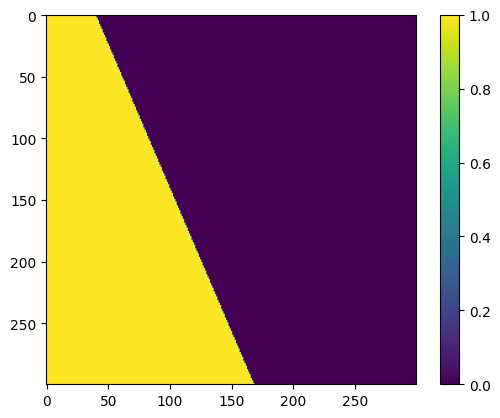

In [4]:
# TODO line_6 = ...
line_6 = geometry.cross([70, 70, 1], [0, 40, 1])

a, b, c = line_6
x, y = np.mgrid[:300, :300]
#plt.imshow(a*x + b*y + c)
plt.imshow(a*x + b*y + c > 0)
plt.colorbar()
line_6

The **point** at the intersection of **two lines (2D)** is the **vector** that lies within both **planes (3D)**.

In other words, it's a vector orthogonal to both plane normals.

You can *also* compute this with the cross product!

$$p = \ell_1 \times \ell_2$$


##### HW #7

Find the intersection point of the two lines from #4 and #6.

In [6]:
intersection = geometry.cross(line_4, line_6)
intersection

array([-25200, -17600,   -170])

array([148.23529412, 103.52941176,   1.        ])

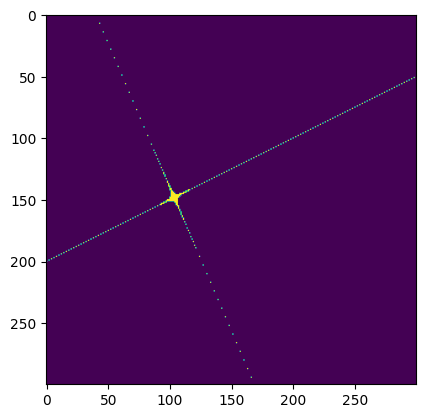

In [7]:
intersection = intersection / intersection[2]


a1, b1, c1 = line_4
a2, b2, c2 = line_6
plt.imshow(np.abs((a1*x + b1*y + c1) * (a2*x + b2*y + c2)) < 1000)

intersection